In [8]:
using Flux
using Statistics
using Plots
using Plots.PlotMeasures
using Sobol
using LaTeXStrings
using MLUtils
import Flux.Losses.mse as mse
using ForwardDiff
include("functions.jl");

In [2]:
problem_domain = [
    0 0.6;
    -1 1
];

In [3]:
sobol_generator = SobolSeq(2)

function sobol_draw!(sobol_gen, draws)
    seq = [next!(sobol_gen) for i = 1:draws]
    return mapreduce(permutedims, vcat, seq)
end

draws = 64

# drawing and scaling inner points
inner_points_scaled = sobol_draw!(sobol_generator, 4*draws)
inner_points = scale_to_domain(inner_points_scaled, problem_domain)

# drawing and scaling time points
init_points_scaled = zeros((draws, 2))
init_points_scaled[:,2] = LinRange(0, 1, draws)
init_points = scale_to_domain(init_points_scaled, problem_domain)

# drawing and scaling space points
boundary_points_scaled = zeros((draws*2, 2))
boundary_points_scaled[begin:draws,1] = LinRange(0, 1, draws)
boundary_points_scaled[draws+1:end,2] = ones(draws)
boundary_points_scaled[draws+1:end,1] = LinRange(0,1, draws)
boundary_points = scale_to_domain(boundary_points_scaled, problem_domain);

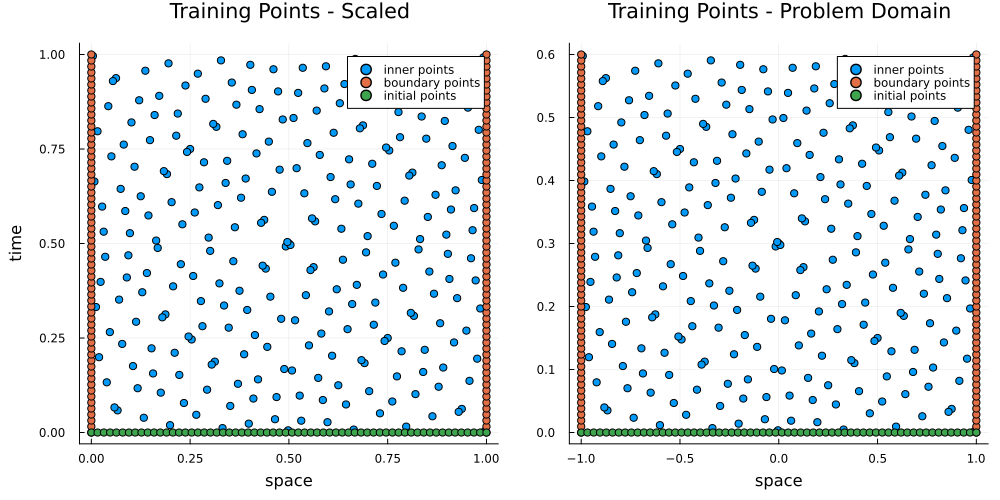

In [4]:
p1 = scatter(inner_points_scaled[:,2], inner_points_scaled[:,1], label="inner points")
title!("Training Points - Scaled")
xlabel!("space")
ylabel!("time")
scatter!(boundary_points_scaled[:,2], boundary_points_scaled[:,1], label="boundary points")
scatter!(init_points_scaled[:,2], init_points_scaled[:,1], label="initial points")

p2 = scatter(inner_points[:,2], inner_points[:,1], label="inner points")
title!("Training Points - Problem Domain")
xlabel!("space")
scatter!(boundary_points[:,2], boundary_points[:,1], label="boundary points")
scatter!(init_points[:,2], init_points[:,1], label="initial points")

plot(p1, p2, layout=(1,2), size=(1000, 500), left_margin=20px, top_margin=20px, bottom_margin=20px)

In [5]:
num_batches = 4

inner_dataset = DataLoader((transpose(inner_points)), batchsize=numobs(transpose(inner_points))÷num_batches, shuffle=true)

boundary_targets = zeros(size(boundary_points)[1])
boundary_dataset = DataLoader((transpose(boundary_points), transpose(boundary_targets)), batchsize=numobs(transpose(boundary_points))÷num_batches, shuffle=true)

function init_cond(x)
    return -sin.(pi .* x)
end

init_targets = init_cond(init_points[:,2])
init_dataset = DataLoader((transpose(init_points), transpose(init_targets)), batchsize=numobs(transpose(init_points))÷num_batches, shuffle=true);

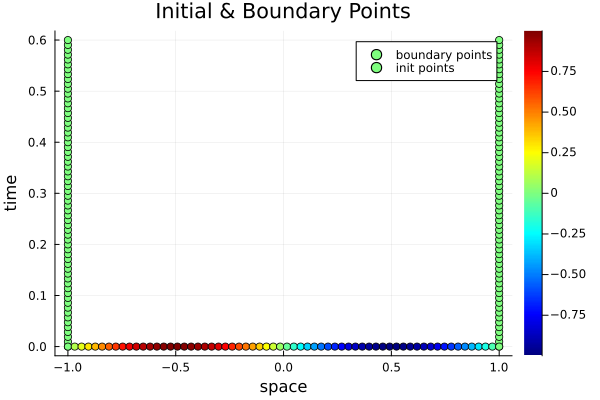

In [6]:
scatter(boundary_points[:,2], boundary_points[:,1], marker_z=boundary_targets, c=:jet, label="boundary points", right_margin=20px)
scatter!(init_points[:,2], init_points[:,1], marker_z=init_targets, c=:jet, label="init points")
title!("Initial & Boundary Points")
xlabel!("space")
ylabel!("time")

In [80]:
input_dim = size(problem_domain)[1]
output_dim = 1
hidden_layers = 4
hidden_size = 20
num_epochs = 1
physics_lambda = 0.1
learning_rate = 0.001

model = Chain(
    Dense(input_dim => hidden_size, tanh),
    Chain([Dense(hidden_size => hidden_size, tanh) for _ in 1:hidden_layers]),
    Dense(hidden_size => output_dim)
)

optimizer = Adam(learning_rate)

datasets = (inner_dataset, boundary_dataset, init_dataset)
for epoch in 1:num_epochs
    for (inner_batch, boundary_batch, init_batch) in zip(inner_dataset, boundary_dataset, init_dataset)
        boundary_loss, boundary_grads = Flux.withgradient(m -> mse(m(boundary_batch[1]), boundary_batch[2]), model)
        init_loss, init_grads = Flux.withgradient(xm -> mse(m(init_batch[1]), init_batch[2]), model)
        loss(x) = mse(model(x))
        dloss_dΘ(x) = gradient(loss, )
    end
end

0.4467793463469097

DataType: KeyError

In [9]:
Flux.params(model)[2]

UndefVarError: UndefVarError: `model` not defined

In [32]:
x = model(inner_points[1,:])

1-element Vector{Float32}:
 -0.07959672

In [27]:
x.elem()

ErrorException: type Array has no field elem

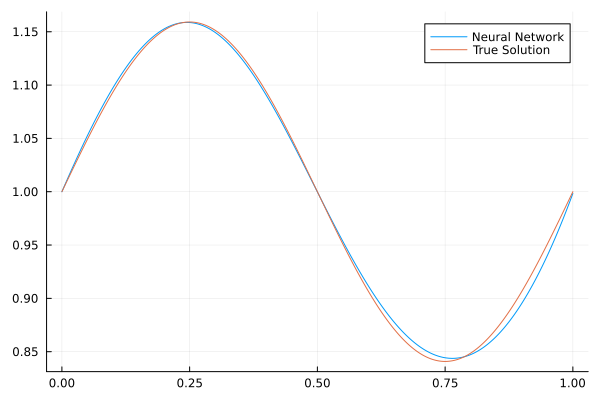

In [28]:
t = 0:0.001:1.0
plot(t, g.(t), label="Neural Network")
plot!(t, 1.0 .+ sin.(2π.*t)/2π, label="True Solution")